In [44]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import nibabel as nib

import monai
from monai.networks.nets import UNETR, UNet
from monai.utils import first
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, SmartCacheDataset
from monai.inferers import SliceInferer
import json
from time import sleep

In [58]:
#Read Data
df = pd.read_csv('Prostate_Cancer_TFM/Files/PICAI/partition_1_cv.csv')

#Read folds and split data
json_path = "/nvmescratch/ceib/Prostate/workdir/splits/picai_nnunet/splits.json"
with open(json_path, "r") as f:
    splits = json.load(f)

#Get the first fold
for i,fold in enumerate(splits):
    train = fold['train']
    val = fold['val']
    
    subjects_to_remove = ['10251_1000255', '10319_1000325', '11050_1001070', '11214_1001237', '11261_1001284','10233_1000237','11032_1001052']
    train = [x for x in train if x not in subjects_to_remove]
    val = [x for x in val if x not in subjects_to_remove]


    df['index'] = df['patient_id'].astype(str)+'_'+df['study_id'].astype(str)
    df.set_index('index', inplace=True)

    df.loc[train,f'Fold {i}']='train'
    df.loc[val,f'Fold {i}']='val'

In [59]:
df[df.label==1]

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,...,filepath_labelAI_cropped,filepath_seg_zones,filepath_seg_zones_cropped,PIRADS,cv_partition,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4
index,,,,,,,,,,,,,,,,,,,,,
10405_1000412,10405,1000412,2012-06-14,58,5.20,0.12,40.00,MRBx,3+4,2,...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,2.0,3,train,val,train,train,train
10537_1000547,10537,1000547,2017-11-12,73,15.00,0.24,63.76,MRBx,4+3,3,...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,4,train,train,train,train,test
11074_1001096,11074,1001096,2012-03-03,62,6.51,0.19,35.00,MRBx,"4+3,3+4","3,2",...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,3.0,1,train,train,val,train,train
10458_1000466,10458,1000466,2018-07-10,70,6.00,0.10,61.00,SysBx+MRBx,"3+4,3+4,0+0","2,2,0",...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,4,train,train,train,train,test
10451_1000459,10451,1000459,2012-07-05,68,11.00,0.21,52.00,MRBx,"N/A,0+0,4+3","0,3",...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,3.0,3,train,train,train,train,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10631_1000646,10631,1000646,2019-11-03,76,9.30,0.22,42.00,SysBx,4+3,3,...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,1,train,test,train,train,train
11009_1001029,11009,1001029,2018-02-17,65,12.40,0.08,149.00,SysBx+MRBx,3+4,2,...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,5,test,train,train,train,train
10837_1000853,10837,1000853,2019-09-05,69,9.30,0.25,37.00,SysBx+MRBx,"3+4,3+4","2,2",...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,1,train,test,train,train,train


In [61]:
#Check images

fold = 0

format_load = "nifti"  #'nifti', mha, cropped
df["depth"] = df["filepath_t2w_" + format_load].apply(lambda path_file: nib.load(path_file).shape[0])
df["heigth"] = df["filepath_t2w_" + format_load].apply(lambda path_file: nib.load(path_file).shape[1])
df["weigth"] = df["filepath_t2w_" + format_load].apply(lambda path_file: nib.load(path_file).shape[2])
df = df[(df["heigth"] != 0) & (df["depth"] != 0)]
df = df[df["filepath_t2w_" + format_load].notna()].reset_index()

df = df[(df["heigth"] > 96) & (df["depth"] > 96)]

data_picai = df

data_picai_human = data_picai[data_picai["human_labeled"] == 1]
data_picai.drop(data_picai_human.index, inplace=True)

data_picai = data_picai[
    [
        "filepath_t2w_" + format_load,
        "filepath_adc_" + format_load,
        "filepath_hbv_" + format_load,
        "filepath_labelAI_cropped",
        "filepath_seg_zones_cropped",
        f'Fold {fold}',
        "label"
    ]
]
data_picai_human = data_picai_human[
    [
        "filepath_t2w_" + format_load,
        "filepath_adc_" + format_load,
        "filepath_hbv_" + format_load,
        "filepath_label_cropped",
        "filepath_seg_zones_cropped",
        f'Fold {fold}',
        "label"
    ]
]

df = pd.DataFrame(
    {
        "t2w": list(data_picai["filepath_t2w_" + format_load].values)
        + list(data_picai_human["filepath_t2w_" + format_load].values),
        "adc": list(data_picai["filepath_adc_" + format_load].values)
        + list(data_picai_human["filepath_adc_" + format_load].values),
        "dwi": list(data_picai["filepath_hbv_" + format_load].values)
        + list(data_picai_human["filepath_hbv_" + format_load].values),
        "zones": list(data_picai["filepath_seg_zones_cropped"].values) + list(data_picai_human["filepath_seg_zones_cropped"].values),
        "label": list(data_picai["filepath_labelAI_cropped"].values) + list(data_picai_human["filepath_label_cropped"].values),
        "partition": list(data_picai[f'Fold {fold}'].values) + list(data_picai_human[f'Fold {fold}'].values),
        "csPCa":list(data_picai["label"].values) + list(data_picai_human["label"].values),
    }
)

In [62]:
df[df.csPCa==1]

,t2w,adc,dwi,zones,label,partition,csPCa
7,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/cropped/label...,train,1
20,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/cropped/label...,train,1
38,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/cropped/label...,train,1
53,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/cropped/label...,train,1
55,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/cropped/label...,train,1
...,...,...,...,...,...,...,...
1253,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/cropped/label...,train,1
1257,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/cropped/label...,train,1
1258,/nvmescratch/ceib/Prostate/input/images_nii/11...,/nvmescratch/ceib/Prostate/input/images_nii/11...,/nvmescratch/ceib/Prostate/input/images_nii/11...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/cropped/label...,test,1
1259,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/images_nii/10...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/cropped/label...,train,1


In [86]:
img_columns=["t2w","adc","dwi"]#,"adc","dwi"]
label_column=["label"]
transforms = monai.transforms.Compose(
        [
            monai.transforms.LoadImaged(keys=img_columns+label_column,reader="NibabelReader",image_only=True),
            monai.transforms.AsDiscreted(keys=label_column,threshold=1), #Convert values greater than 1 to 1
            monai.transforms.EnsureChannelFirstd(keys=img_columns+label_column),
            #monai.transforms.Resized(keys=img_columns+label_column,spatial_size=(128,128,-1),mode=("trilinear","trilinear","trilinear","nearest","nearest")),#SAMUNETR: Reshape to have the same dimension
            monai.transforms.ResampleToMatchd(keys=["adc","dwi","label"],key_dst="t2w",mode=("bilinear","bilinear","nearest")),#Resample images to t2 dimension
            monai.transforms.ScaleIntensityd(keys=["t2w","dwi"],minv=0.0, maxv=1.0),
            monai.transforms.ScaleIntensityRanged(
            keys=["adc"],
            a_min=315.09063720703125,
            a_max=2321.78369140625,
            b_min=0.0,
            b_max=1.0,
            clip=True,
            ),
            monai.transforms.NormalizeIntensityd(keys=img_columns,channel_wise=True),
            monai.transforms.ConcatItemsd(keys=img_columns, name='image', dim=0),
            monai.transforms.ConcatItemsd(keys=label_column, name='label', dim=0),
            monai.transforms.SpatialPadd(keys=["image", "label"], spatial_size=(128,128,-1)),
            monai.transforms.RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(128, 128, -1),
                pos=3,
                neg=1,
                num_samples=3,
                image_key="image",
                image_threshold=0,
            ),
            monai.transforms.RandRotated(
                keys=["image", "label"],
                prob=0.2,
                range_x=(-30.0 / 360 * 2.0 * np.pi, 30.0 / 360 * 2.0 * np.pi),
                range_y=(-30.0 / 360 * 2.0 * np.pi, 30.0 / 360 * 2.0 * np.pi),
                range_z=(-30.0 / 360 * 2.0 * np.pi, 30.0 / 360 * 2.0 * np.pi),
                mode=["bilinear", "nearest"],
            ),
            monai.transforms.RandScaleIntensityd(keys=["image"], prob=0.2, factors=(0.7, 1.4)),
            monai.transforms.RandGaussianNoised(keys="image", prob=0.1, mean=0, std=0.1),
            monai.transforms.RandGaussianSmoothd(keys="image", prob=0.1, sigma_x=(0.5, 1)),
            monai.transforms.RandAdjustContrastd(keys="image", prob=0.15, gamma=(0.75, 1.25)),
            monai.transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[0]),
            monai.transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[1]),
            monai.transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=[2]),
            monai.transforms.ToTensord(keys=["image", "label"]),
            
        ]
    )

In [81]:
# Show original images without transforms
original_images = monai.transforms.LoadImaged(keys=img_columns+label_column,reader="NibabelReader",image_only=True)(df.iloc[53])

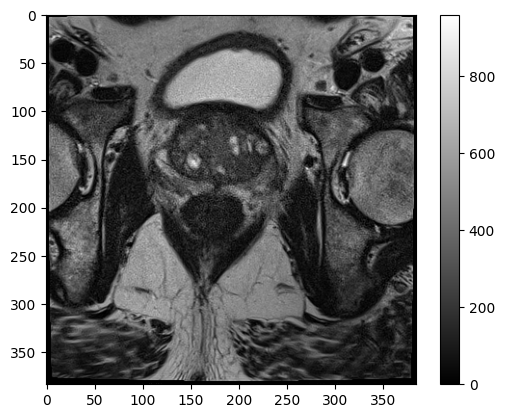

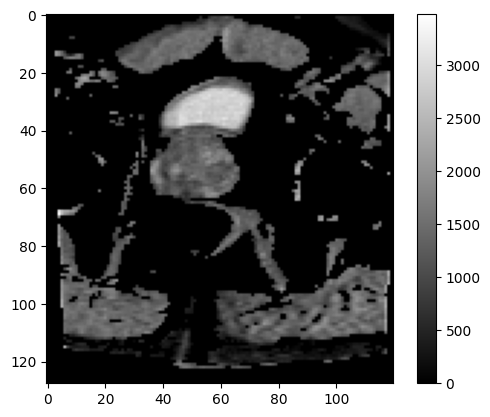

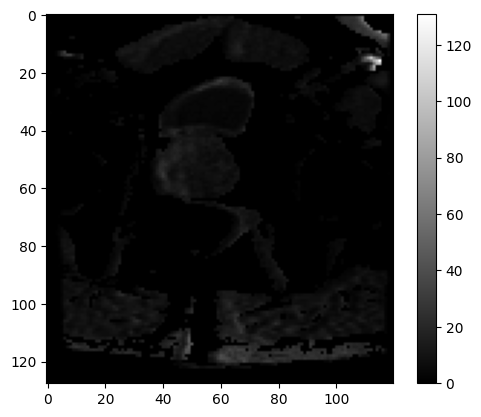

In [82]:
#Plot image middle image slice
import matplotlib.pyplot as plt


plt.imshow(original_images["t2w"][...,12].T, cmap="gray")
plt.colorbar()
plt.show()


plt.imshow(original_images["adc"][...,12].T, cmap="gray")
plt.colorbar()
plt.show()

plt.imshow(original_images["dwi"][...,12].T, cmap="gray")
plt.colorbar()
plt.show()



In [107]:
transformed_images = transforms(df.iloc[53])

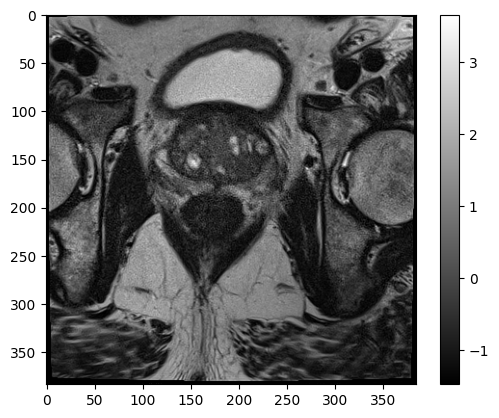

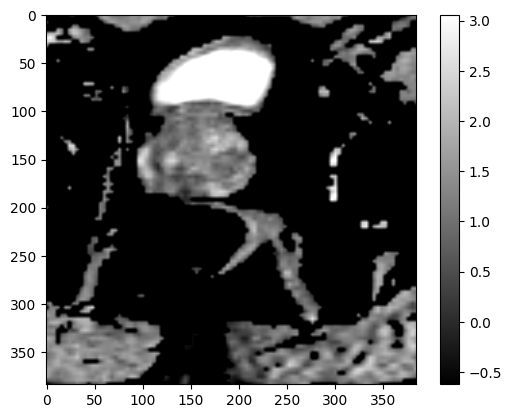

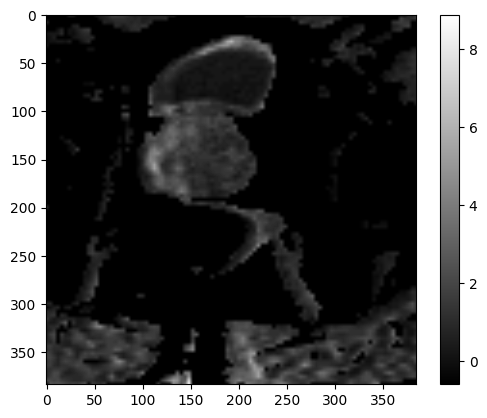

In [94]:
import matplotlib.pyplot as plt


plt.imshow(transformed_images[0]["t2w"][...,12].T, cmap="gray")
plt.colorbar()
plt.show()


plt.imshow(transformed_images[0]["adc"][...,12].T, cmap="gray")
plt.colorbar()
plt.show()

plt.imshow(transformed_images[0]["dwi"][...,12].T, cmap="gray")
plt.colorbar()
plt.show()

In [89]:
len(transformed_images)

3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


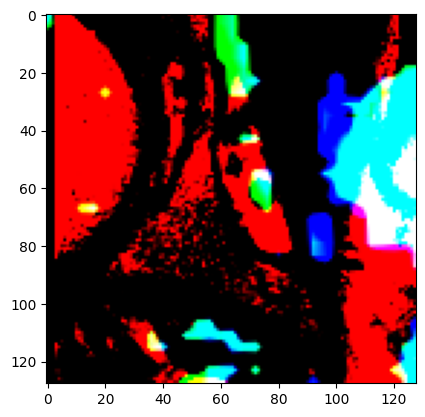

In [109]:
plt.imshow(transformed_images[0]["image"][...,12].T)
